# Case 21.6 Segmenting Consumers of Bath Soap

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Case study included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

In [1]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier


import matplotlib.pylab as plt

from dmba import classificationSummary, gainsChart

from IPython.display import display_html


DATA = Path('.').resolve().parent / 'data'

## Load the data

In [2]:
bathSoap_df = pd.read_csv(DATA / 'BathSoapHousehold.csv')
print(bathSoap_df.shape)
bathSoap_df.head()

(600, 46)


,Member id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,...,PropCat 6,PropCat 7,PropCat 8,PropCat 9,PropCat 10,PropCat 11,PropCat 12,PropCat 13,PropCat 14,PropCat 15
0,1010010,4,3,10,1,4,4,2,4,1,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.028037,0.0,0.130841,0.339564
1,1010020,3,2,10,2,2,4,4,2,1,...,0.347048,0.026834,0.016100,0.014311,0.0,0.059034,0.000000,0.0,0.080501,0.000000
2,1014020,2,3,10,2,4,5,6,4,1,...,0.121212,0.033550,0.010823,0.008658,0.0,0.000000,0.016234,0.0,0.561688,0.003247
3,1014030,4,0,0,0,4,0,0,5,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.600000,0.000000
4,1014190,4,1,10,2,3,4,4,3,1,...,0.000000,0.000000,0.048193,0.000000,0.0,0.000000,0.000000,0.0,0.144578,0.000000


# Step 1:
Use $k$-means clustering to identify clusters of households based on:

1. The variables that describe purchase behavior (including brand loyalty)
2. The variables that describe the basis for purchase
3. The variables that describe both purchase behavior and basis of purchase

Note 1: How should $k$ be chosen?  Think about how the clusters would be used.  It is likely that the marketing efforts would support two to five different promotional approaches.

Note 2: How should the percentages of total purchases comprised by various brands be treated?  Isn't a customer
who buys all brand A just as loyal as a customer who buys all brand B?  What will be the effect on any distance measure of using the brand share variables as is?  Consider using a single derived variable.

We look first at clusters based on purchase behavior, then clusters based on the basis for purchase, then clusters based on both. The complexity of marketing to 5 segments would probably not be supported by clustering just based on purchase behavior, or clustering just based on basis for purchase, so we will look at 2-3 clusters for those variables, and more when we cluster using both sets of variables.

In choosing  𝑘 , we would seek a  𝑘  that produces clusters that are distinct and separate from one another, in ways (variables) that are translatable into marketing actions. The variables we have been asked to consider are those that relate to purchase behavior (volume and frequency of purchase, brand loyalty), and a separate set that relate to the basis for purchase (response to promotions, pricing, and selling proposition).

In [3]:
# Group columns into sets for further analysis
demographicIndicators = bathSoap_df.columns[1:11]
purchaseIndicator = bathSoap_df.columns[11:19]
withinPromotionIndicator = bathSoap_df.columns[19:22]
brandIndicator = bathSoap_df.columns[22:30]
otherBrandIndicator = bathSoap_df.columns[30:31]
priceCategoryIndicator = bathSoap_df.columns[31:35]
sellingPropertyIndicator = bathSoap_df.columns[35:46]

print('Demographic', demographicIndicators)
print('Purchase', purchaseIndicator)
print('Promotion', withinPromotionIndicator)
print('Brand', brandIndicator)
print('Other brand', otherBrandIndicator)
print('Price category', priceCategoryIndicator)
print('Selling property', sellingPropertyIndicator)

Demographic Index(['SEC', 'FEH', 'MT', 'SEX', 'AGE', 'EDU', 'HS', 'CHILD', 'CS',
       'Affluence Index'],
      dtype='object')
Purchase Index(['No. of Brands', 'Brand Runs', 'Total Volume', 'No. of  Trans', 'Value',
       'Trans / Brand Runs', 'Vol/Tran', 'Avg. Price '],
      dtype='object')
Promotion Index(['Pur Vol No Promo - %', 'Pur Vol Promo 6 %', 'Pur Vol Other Promo %'], dtype='object')
Brand Index(['Br. Cd. 57, 144', 'Br. Cd. 55', 'Br. Cd. 272', 'Br. Cd. 286',
       'Br. Cd. 24', 'Br. Cd. 481', 'Br. Cd. 352', 'Br. Cd. 5'],
      dtype='object')
Other brand Index(['Others 999'], dtype='object')
Price category Index(['Pr Cat 1', 'Pr Cat 2', 'Pr Cat 3', 'Pr Cat 4'], dtype='object')
Selling property Index(['PropCat 5', 'PropCat 6', 'PropCat 7', 'PropCat 8', 'PropCat 9',
       'PropCat 10', 'PropCat 11', 'PropCat 12', 'PropCat 13', 'PropCat 14',
       'PropCat 15'],
      dtype='object')


## Clusters based on "purchase behavior"
Note: Some thought is needed about brand loyalty. For brand loyalty indicators, we have data on 
    
1. percent of purchases devoted to major brands (i.e. is a customer a total devotee of brand A?), `brandIndicator` 
2. a catch-all variable for percent of purchases devoted to other smaller brands (to reduce complexity of analysis), and `otherBrandIndicator`
3. a derived variable that indicates the maximum share devoted to any one brand. 
    
Since CRISA is compiling this data for general marketing use, and not on behalf of one particular brand, we can
say a customer who is fully devoted to brand A is similar to a customer fully devoted to brand B - both
are fully loyal customers in their behavior. But if we include all the brand shares in the clustering, the
analysis will treat those two customers as very different. 

1. Number of different brands: `No. of Brands`
2. Switching between brands: `Brand Runs`
3. Proportion of purchases that go to different brands: We use the information in the `brandIndicator` to determine the maximum proportion a customer spends on one brand (new variable `maxBrandIndicator`)

We derive the value of `maxBrandIndicator` by taking the maximum of all specific brand indicators.

In [4]:
bathSoap_df['maxBrandIndicator'] = bathSoap_df[brandIndicator].max(axis=1)

For this analysis, we use all `purchaseIndicator`, `maxBrandIndicator` and `otherBrandIndicator` as a description of the customers purchase behavior

In [5]:
behaviorIndicator = list(purchaseIndicator) + list(otherBrandIndicator) + ['maxBrandIndicator']
print(behaviorIndicator)

['No. of Brands', 'Brand Runs', 'Total Volume', 'No. of  Trans', 'Value', 'Trans / Brand Runs', 'Vol/Tran', 'Avg. Price ', 'Others 999', 'maxBrandIndicator']


### Normalizing the data and definition of helper functions

In [6]:
# Normalize the data
bathSoap_df_norm = (bathSoap_df - bathSoap_df.mean())/bathSoap_df.std()

def clusterSizes(kmeans):
    return pd.Series(kmeans.labels_).value_counts().sort_index()


def clusterCenters(kmeans, indicator):
    return bathSoap_df_norm[indicator].groupby(kmeans.labels_).mean()

### Two clusters

In [7]:
clusters = KMeans(n_clusters=2, random_state=1).fit(bathSoap_df_norm[behaviorIndicator])
print(clusterSizes(clusters))
clusterCenters(clusters, behaviorIndicator)

0    317
1    283
dtype: int64


,No. of Brands,Brand Runs,Total Volume,No. of Trans,Value,Trans / Brand Runs,Vol/Tran,Avg. Price,Others 999,maxBrandIndicator
0,0.483611,0.632865,0.158222,0.522115,0.306960,-0.261283,-0.285383,0.279689,0.488928,-0.588026
1,-0.541712,-0.708898,-0.177232,-0.584843,-0.343838,0.292674,0.319669,-0.313291,-0.547669,0.658673


Comment: The two clusters are well-separated on everything, except transaction volume. 
- Cluster 0 (n=317) is high activity & value, with low loyalty. 
- Cluster 1 (n=283) is the reverse. 

("Value" here is the meaning attached to the variable - total dollar value of purchases, not some broader meaning.)
Note: Due to the randomization element in the k-means process, different runs can produce different
cluster results.

In [8]:
clusters = KMeans(n_clusters=3, random_state=1).fit(bathSoap_df_norm[behaviorIndicator])
print(clusterSizes(clusters))
clusterCenters(clusters, behaviorIndicator)

0    166
1    259
2    175
dtype: int64


,No. of Brands,Brand Runs,Total Volume,No. of Trans,Value,Trans / Brand Runs,Vol/Tran,Avg. Price,Others 999,maxBrandIndicator
0,0.950737,1.099320,0.635975,1.082139,0.767309,-0.254805,-0.190209,0.127343,0.254809,-0.477311
1,-0.275933,-0.215651,-0.532365,-0.415564,-0.454992,-0.247321,-0.273599,0.228323,0.599030,-0.532205
2,-0.493460,-0.723619,0.184632,-0.411452,-0.054460,0.607736,0.585353,-0.458712,-1.128269,1.240427


Comment: 
- Cluster 0 (n=166) is not at all loyal, favoring many brands, and of high value.
- Cluster 1 (n=259) is also not very loyal, but may be of the least interest since its customers have the lowest value.
- Cluster 2 (n=175) is highly loyal, favoring main brands and bigger individual purchases, with middling overall value. 

## Clusters based on "basis for purchase"
The variables used are: `Pur Vol No Promo - %`, `Pur Vol Promo 6 %`, `Pur Vol Other Promo %`, all price categories, selling propositions 5 and 14 (most people seemed to be responding to one or the other of these promotions/propositions).

In [9]:
purchaseBasisIndicator = list(withinPromotionIndicator) + list(priceCategoryIndicator) 
purchaseBasisIndicator.extend(['PropCat 5', 'PropCat 14'])
print(purchaseBasisIndicator)

['Pur Vol No Promo - %', 'Pur Vol Promo 6 %', 'Pur Vol Other Promo %', 'Pr Cat 1', 'Pr Cat 2', 'Pr Cat 3', 'Pr Cat 4', 'PropCat 5', 'PropCat 14']


In [10]:
clusters = KMeans(n_clusters=2, random_state=1).fit(bathSoap_df_norm[purchaseBasisIndicator])
print(clusterSizes(clusters))
clusterCenters(clusters, purchaseBasisIndicator)

0     77
1    523
dtype: int64


,Pur Vol No Promo - %,Pur Vol Promo 6 %,Pur Vol Other Promo %,Pr Cat 1,Pr Cat 2,Pr Cat 3,Pr Cat 4,PropCat 5,PropCat 14
0,0.205410,-0.402586,0.179079,-0.791774,-1.134101,2.387450,-0.334659,-1.105730,2.391835
1,-0.030242,0.059272,-0.026365,0.116571,0.166971,-0.351498,0.049271,0.162794,-0.352144


Comment: The two clusters are well-separated across most variables. 
- Cluster 0 (n=77) is notable for its responsiveness to price category 3 and selling proposition 14 coupled with aversion to price categories 1 and 2, and selling proposition 5.
- Cluster 1 (n=523) shows a less clear profile

In [11]:
clusters = KMeans(n_clusters=3, random_state=1).fit(bathSoap_df_norm[purchaseBasisIndicator])
print(clusterSizes(clusters))
clusterCenters(clusters, purchaseBasisIndicator)

0     74
1    429
2     97
dtype: int64


,Pur Vol No Promo - %,Pur Vol Promo 6 %,Pur Vol Other Promo %,Pr Cat 1,Pr Cat 2,Pr Cat 3,Pr Cat 4,PropCat 5,PropCat 14
0,0.256679,-0.434717,0.135482,-0.802892,-1.152356,2.432767,-0.352060,-1.136908,2.436529
1,0.349656,-0.287933,-0.208460,0.062932,0.258829,-0.336154,-0.042901,0.195635,-0.335935
2,-1.742234,1.605076,0.818594,0.334189,-0.265602,-0.369225,0.458320,0.002103,-0.373063


Comment: 
- Cluster 0 (n=74) has the same profile as cluster 0 in the two cluster case.
- Cluster 1 (n=429) corresponds mainly to cluster 1 in the two cluster case.
- Cluster 2 (n=97) needs promostions, likes price categories 1 and 4, and is not responsive to the two selling propositions. 

## Clusters based on all of the above variables

In [12]:
combinedIndicator = behaviorIndicator + purchaseBasisIndicator 
clusters = KMeans(n_clusters=2, random_state=1).fit(bathSoap_df_norm[combinedIndicator])
print(clusterSizes(clusters))
clusterCenters(clusters, combinedIndicator).transpose()

0    528
1     72
dtype: int64


,0,1
No. of Brands,0.076539,-0.561285
Brand Runs,0.107685,-0.789690
Total Volume,-0.017671,0.129590
No. of Trans,0.057712,-0.423219
Value,0.070433,-0.516510
Trans / Brand Runs,-0.143673,1.053602
Vol/Tran,-0.074915,0.549376
Avg. Price,0.178255,-1.307201
Others 999,0.171574,-1.258207
maxBrandIndicator,-0.193782,1.421067


Comment: The two clusters are separated on almost all variables, Value being an important exception. 

In [13]:
def clusterDemographics(kmeans):
    return bathSoap_df[demographicIndicators].groupby(kmeans.labels_).mean()

clusterDemographics(clusters).transpose()

,0,1
SEC,2.375000,3.416667
FEH,2.049242,2.041667
MT,8.250000,7.652778
SEX,1.763258,1.555556
AGE,3.246212,2.972222
EDU,4.268939,2.388889
HS,4.198864,4.138889
CHILD,3.202652,3.458333
CS,0.937500,0.888889
Affluence Index,18.159091,8.666667


Cluster 1 (n=72) is the more loyal, with lower socioeconomic status, educational level, and affluence.

In [14]:
def display_side_by_side(*args):
    html_str = ''.join(df.to_html() for df in args)
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


combinedIndicator = behaviorIndicator + purchaseBasisIndicator 
clusters = KMeans(n_clusters=3, random_state=1).fit(bathSoap_df_norm[combinedIndicator])
print(clusterSizes(clusters))
display_side_by_side(clusterCenters(clusters, combinedIndicator).transpose(),
                     clusterDemographics(clusters).transpose())

0     72
1    248
2    280
dtype: int64


,0,1,2
No. of Brands,-0.508532,-0.346872,0.437995
Brand Runs,-0.761636,-0.474887,0.616463
Total Volume,0.137098,0.043343,-0.073643
No. of Trans,-0.390544,-0.412782,0.466032
Value,-0.513577,-0.042678,0.169863
Trans / Brand Runs,1.004705,-0.018763,-0.241734
Vol/Tran,0.520628,0.373779,-0.464937
Avg. Price,-1.310393,-0.196607,0.511096
Others 999,-1.248331,-0.225977,0.521151
maxBrandIndicator,1.396638,0.288194,-0.614393


Comment:
- Cluster 0: (n=72) Highly loyal, low value, highly responsive to price category 3 and selling proposition 14.
- Cluster 1: (n=252) Responsive to price category 2 and selling proposition 5, otherwise somewhat middling.
- Cluster 2: (n=278) Low brand loyalty, responsive to price category 1

In [15]:
combinedIndicator = behaviorIndicator + purchaseBasisIndicator 
clusters = KMeans(n_clusters=4, random_state=1).fit(bathSoap_df_norm[combinedIndicator])
print(clusterSizes(clusters))
display_side_by_side(clusterCenters(clusters, combinedIndicator).transpose(),
                     clusterDemographics(clusters).transpose())

0    109
1    201
2     70
3    220
dtype: int64


,0,1,2,3
No. of Brands,-0.414643,0.837833,-0.583893,-0.374254
Brand Runs,-0.318502,0.973787,-0.800569,-0.477157
Total Volume,-0.651976,0.290887,0.083386,0.030727
No. of Trans,-0.426788,0.824516,-0.433421,-0.403947
Value,-0.218712,0.388624,-0.555616,-0.069913
Trans / Brand Runs,-0.140179,-0.299278,1.037226,0.012857
Vol/Tran,-0.458972,-0.360995,0.513840,0.393724
Avg. Price,1.358148,0.063462,-1.318253,-0.311438
Others 999,0.514018,0.368089,-1.264136,-0.188747
maxBrandIndicator,-0.418273,-0.552509,1.421065,0.259871


Comment:
- Cluster 0 (n=109) is characterized by low volume, low loyalty, and sensitivity to promotions and price (responsive to cat. 1, unresponsive to 2 and 3), and unmoved by selling proposition. Demographically, it is affluent, of high socio-economic status, and has relatively small family size.
- Cluster 1 (n=201) is distinguished mostly by the purchase behavior variables - it has low brand loyalty together with high value, volume and frequency. The brand switching seems to be intrinsic - this group is not particularly responsive to promotions, pricing or selling propositions. Demographically it is relatively affluent and educated.
- Cluster 2 (n=70) stands out in both groups of variables - it has high loyalty, low value and price per purchase, and very differential response to price (unresponsive to categories 1, 2 and 4, highly responsive to category 3), and selling proposition (unresponsive to #5, highly responsive to #14). Demographically it has low affluence and education.
- Cluster 3 (n=220) is a "gray" cluster, it is not characterized by very extreme/distinctive values across all variables, but is responsive to price category 2 and selling proposition 5 (similar to cluster 1 in the 3-cluster analysis). Demographically it is relatively affluent and educated. 

# Step 2:
Select what you think is the best segmentation and comment on the characteristics (demographic, brand loyalty, and basis for purchase) of these clusters.  (This information would be used to guide the development of advertising and promotional campaigns.)

There is no single "right" approach to clustering; different approaches are feasible depending on
different marketing purposes. CRISA is a marketing agency and owns the data, which it collected at
considerable expense, so it will want to be able to use both the data and the segmentation analysis in
different ways for different clients. Here are just a few possible marketing approaches:

1. Establishing named customer "personas," corresponding to the cluster segments, for use by a client's sales and marketing teams.
2. Establishing named customer "personas," corresponding to the cluster segments, for use by CRISA in providing marketing services to clients.
3. "Capture affluent market share" campaign for a client who wants to target more affluent consumers who are not wedded to their current brand, and secure more brand share. 
4. "Down market" campaign for a data-poor client to build a "value" brand for less affluent consumers, much as Dollar General has done in the U.S. 

note: The difference between #1 and #2 is that #1, being confined to a single client, can use that client's
customer data to refine and do more analysis. #2 would have to rely on the data collected by CRISA.

# Step 3:
Develop a model that classifies the data into these segments. Since this information would most likely be used in targeting direct-mail promotions, it would be useful to select a market segment that would be defined as a _success_ in the classification model.

This "down market" scenario is the one we will explore further to develop a predictive model, and classify people into either "value conscious" or not. "Data poor" means that the client has, or can get, demographic data on their customers, but not detailed purchase data (particularly involving other brands). So a predictive model is to be built using just demographic data. We will look at the results of clustering into two segments based on CRISA's own detailed purchase data, then classify people into those two segments.

Recall our characterization of the two segments:

Comment: The two clusters are separated on almost all variables, Value being an important exception. Cluster 1 (n=72) is the more loyal, with lower socioeconomic status and affluence.

So our "success" category is cluster 1, the less affluent group, lower socioeconomic group, which also turns out to be highly loyal and, as it happens, spends roughly as much as the more affluent group. This is a promising group around which to build a down-market brand strategy.

To build the model, we will be able to only use demographic information. CRISA will not have the detailed purchase information for its client's customers.

In [16]:
clusters = KMeans(n_clusters=2, random_state=1).fit(bathSoap_df_norm[combinedIndicator])
print(clusterSizes(clusters))

modelData_df = bathSoap_df[demographicIndicators].copy()
modelData_df = pd.get_dummies(modelData_df, columns=['MT', 'FEH'])
modelData_df['y'] = [1 if label == 1 else 0 for label in clusters.labels_]

train_df, valid_df = train_test_split(modelData_df, test_size=0.4, random_state=1)

train_X, train_y = train_df.drop(columns=['y']), train_df['y']
valid_X, valid_y = valid_df.drop(columns=['y']), valid_df['y']

0    528
1     72
dtype: int64


### Logistic regression

Confusion Matrix (Accuracy 0.8833)

       Prediction
Actual   0   1
     0 207   2
     1  26   5
Number of customers of interest in validaton set 31
Number of customers of interest in 20% top-ranked 18
Ratio 0.58


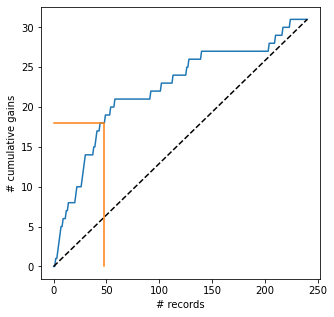

In [17]:
model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
model.fit(train_X, train_y)

model_pred = model.predict_proba(valid_X)
result = pd.DataFrame({
    'actual': valid_y,
    'p(0)': [p[0] for p in model_pred],
    'p(1)': [p[1] for p in model_pred],
    'predicted': model.predict(valid_X),
})
result = result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(result.actual, result.predicted)

ax = gainsChart(result.actual, figsize=[5, 5])
nx = round(valid_df.shape[0] * 0.2)
ny = sum(result.actual[0:nx])
ax.plot([nx, nx,0], [0, ny, ny])

print('Number of customers of interest in validaton set', valid_y.sum())
print('Number of customers of interest in 20% top-ranked', ny)
print(f'Ratio {ny / valid_y.sum():.2f}')

### Decision tree

Confusion Matrix (Accuracy 0.8833)

       Prediction
Actual   0   1
     0 202   7
     1  21  10
Number of customers of interest in validaton set 31
Number of customers of interest in 20% top-ranked 17
Ratio 0.55


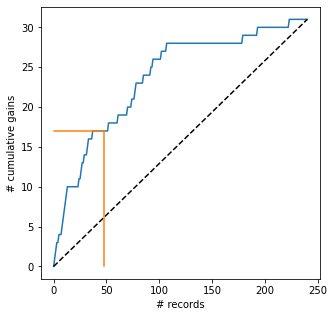

In [18]:
model = DecisionTreeClassifier(max_depth=3, random_state=1)
model.fit(train_X, train_y)

model_pred = model.predict_proba(valid_X)
result = pd.DataFrame({
    'actual': valid_y,
    'p(0)': [p[0] for p in model_pred],
    'p(1)': [p[1] for p in model_pred],
    'predicted': model.predict(valid_X),
})
result = result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(result.actual, result.predicted)

ax = gainsChart(result.actual, figsize=[5, 5])
nx = round(valid_df.shape[0] * 0.2)
ny = sum(result.actual[0:nx])
ax.plot([nx, nx,0], [0, ny, ny])

print('Number of customers of interest in validaton set', valid_y.sum())
print('Number of customers of interest in 20% top-ranked', ny)
print(f'Ratio {ny / valid_y.sum():.2f}')

### Random forest classifier

Confusion Matrix (Accuracy 0.8583)

       Prediction
Actual   0   1
     0 201   8
     1  26   5
Number of customers of interest in validaton set 31
Number of customers of interest in 20% top-ranked 18
Ratio 0.58


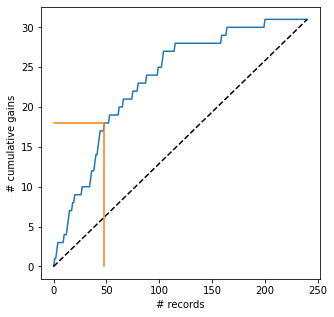

In [19]:
model = RandomForestClassifier(random_state=1, n_estimators=100)
model.fit(train_X, train_y)

model_pred = model.predict_proba(valid_X)
result = pd.DataFrame({
    'actual': valid_y,
    'p(0)': [p[0] for p in model_pred],
    'p(1)': [p[1] for p in model_pred],
    'predicted': model.predict(valid_X),
})
result = result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(result.actual, result.predicted)

ax = gainsChart(result.actual, figsize=[5, 5])
nx = round(valid_df.shape[0] * 0.2)
ny = sum(result.actual[0:nx])
ax.plot([nx, nx,0], [0, ny, ny])

print('Number of customers of interest in validaton set', valid_y.sum())
print('Number of customers of interest in 20% top-ranked', ny)
print(f'Ratio {ny / valid_y.sum():.2f}')

###  Bagging classifier

Confusion Matrix (Accuracy 0.8542)

       Prediction
Actual   0   1
     0 198  11
     1  24   7
Number of customers of interest in validaton set 31
Number of customers of interest in 20% top-ranked 19
Ratio 0.61


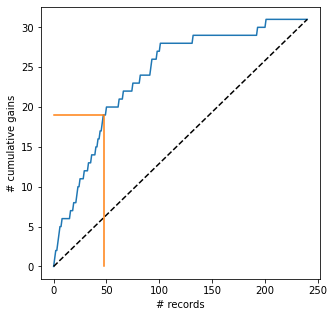

In [20]:
model = BaggingClassifier(random_state=1, n_estimators=100)
model.fit(train_X, train_y)

model_pred = model.predict_proba(valid_X)
result = pd.DataFrame({
    'actual': valid_y,
    'p(0)': [p[0] for p in model_pred],
    'p(1)': [p[1] for p in model_pred],
    'predicted': model.predict(valid_X),
})
result = result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(result.actual, result.predicted)

ax = gainsChart(result.actual, figsize=[5, 5])
nx = round(valid_df.shape[0] * 0.2)
ny = sum(result.actual[0:nx])
ax.plot([nx, nx,0], [0, ny, ny])

print('Number of customers of interest in validaton set', valid_y.sum())
print('Number of customers of interest in 20% top-ranked', ny)
print(f'Ratio {ny / valid_y.sum():.2f}')

### Summary
The analysis of the varies models favors the boosting model. It has both the highest accuracy and the gains chart shows that more records are correctly assigned for 20% of the ranked validation set.

## What's next?
Many data mining algorithms are iterative in an mathematical sense - iteration is used to find a good, if
not best, solution. The modeling process itself is also iterative. In initial exploration, we do not seek the
perfect model, merely something to get started. Results are assessed, and we typically continue with a
modified approach.

Several steps can be explored next to improve predictive performance:

1. Some of the demographic categorical variables may not have much value being treated as is, as ordered categorical variables. They could be reviewed and turned into binary dummies.
2. Instead of using a two-cluster model, a multi-cluster model could be used in hopes of deriving more distinguishable clusters. The non-success clusters could then be consolidated. For example, cluster #2 in the 4-cluster model is similar to our cluster 1 ("success") in the 2-cluster model, only more sharply defined.
3. Demographic predictors could be added to the original clustering process.
4. The clustering process, which includes a randomization component that yields variability in resulting clusters, can be repeated, to ensure that the cluster labels reflect some degree of stability. Repetition should show some clustering results that are consistent across various runs. Choosing for your labels a clustering result that is very inconsistent with the others could mean that you are labeling your market segments according to a chance fluke.
5. In the real world, going beyond the parameters of this case study, CRISA would probably work with the client to add the client's own purchase data to the model to improve it over time.